In [125]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
from IPython.display import display
def display_matrix(m):
    display(sympy.Matrix(m))
import sympy
import pandas as pd

sympy.init_printing()

In [126]:
S0 = 100
T = 1
mu = 0.05
sigma = 0.2
lam = 1
I = 100
m = 0
v = 0.3
paths = 100
K = 99
df = np.exp(-mu*T)

# Levy processes

In [127]:
def matrix(paths, lam=lam):
    np.random.seed(42)
    matrix = np.zeros((paths, I))
    for k in range(paths):
        X = np.zeros(I)
        S = np.zeros(I)

        X[0] = np.log(S0)
        S[0] = S0
        dt = T / I
    
        for i in range(1,I):
            Z = np.random.standard_normal()
            N = np.random.poisson(lam * dt)
            Y = np.exp(np.random.normal(m,v,N))
    
            if N == 0:
                M = 0
    
            else:
                for j in range(N):
                    M = np.sum(np.log(Y))
                    
            X[i] = X[i-1] + (mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z + M
            S[i] = np.exp(X[i])
        matrix[k] = S
    return matrix


# drop model

def drop(paths):
    np.random.seed(42)
    matrix = np.zeros((paths, I))
    for k in range(paths):
        X = np.zeros(I)
        S = np.zeros(I)

        X[0] = np.log(S0)
        S[0] = S0
        dt = T / I
    
        for i in range(1,I):
            Z = np.random.standard_normal()
            N = np.random.poisson(lam * dt)
            Y = np.exp(np.random.normal(m,v,N))
    
            if N == 0 and X[i-1] > 0:
                X[i] = X[i-1] + (mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z
                S[i] = np.exp(X[i])
            else:
                S[i] = 0
        matrix[k] = S
    return matrix

S_GBM = matrix(paths, lam=0)
S_Merton = matrix(paths)
S_Drop = drop(paths)
print(S_GBM.shape, S_Merton.shape, S_Drop.shape)

(100, 100) (100, 100) (100, 100)


Text(0.5, 1.0, 'Paths')

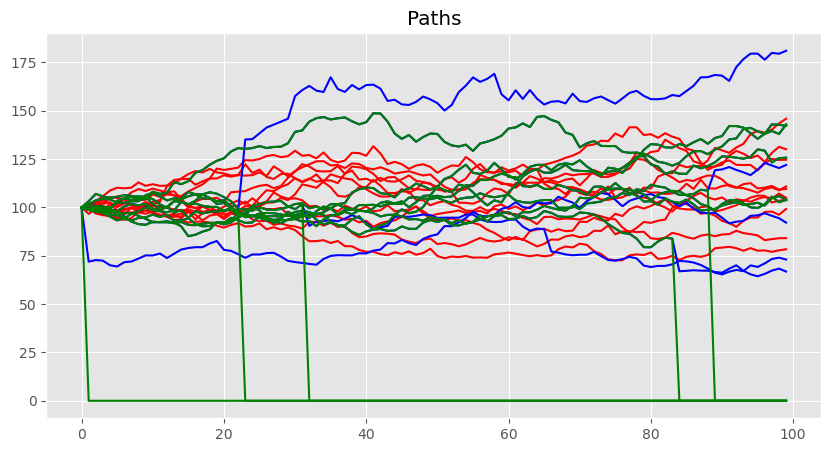

In [128]:
#plot the transposed of each of the matrices side by side
plt.figure(figsize=(10,5))
plt.plot(S_GBM.T[:,:10], c = 'r')
plt.plot(S_Merton.T[:,:10], c = 'b')
plt.plot(S_Drop.T[:,:10], c = 'g')
plt.title('Paths')

## LSM Pricing Algorithm

In [129]:
def LSM(K, S, I, df, basis, deg):
    H = np.maximum(K - S, 0)  # intrinsic values for put option
    V = np.zeros_like(H)  # value matrix
    V[:, -1] = H[:, -1] # set value at maturity equal to intrinsic value
    np.random.seed(42)
    # Valuation by LS Method
    for t in range(I - 2, 0, -1): #start at t = I-2 and go backwards (since we already set t = I-1 to intrinsic value)
        good_paths = H[:, t] > 0  # paths where the intrinsic value is positive
        # the regression is performed only on these paths
        if basis == 'poly':
            rg = np.polyfit(S[good_paths, t], V[good_paths, t + 1] * df, deg)  # polynomial regression
            C = np.polyval(rg, S[good_paths, t])  # evaluation of regression
        elif basis == 'legendre':
            rg = np.polynomial.legendre.legfit(S[good_paths, t], V[good_paths, t + 1] * df, deg)
            C = np.polynomial.legendre.legval(S[good_paths, t], rg)
        elif basis =='laguerre':
            rg = np.polynomial.laguerre.lagfit(S[good_paths, t], V[good_paths, t + 1] * df, deg)
            C = np.polynomial.laguerre.lagval(S[good_paths, t], rg)
        else:
            rg = np.polynomial.hermite.hermfit(S[good_paths, t], V[good_paths, t + 1] * df, deg)
            C = np.polynomial.hermite.hermval(S[good_paths, t], rg)

        exercise = np.zeros(len(good_paths), dtype=bool)  # initialize
        exercise[good_paths] = H[good_paths, t] > C  # paths where it is optimal to exercise

        V[exercise, t] = H[exercise, t]  # set V equal to H where it is optimal to exercise
        V[exercise, t + 1 :] = 0  # set future cash flows, for that path, equal to zero
        discount_path = V[:, t] == 0  # paths where we didn't exercise
        V[discount_path, t] = V[discount_path, t + 1] * df  # set V[t] in continuation region

    V0 = np.mean(V[:, 1]) * df  # discounted expectation of V[t=1]
    return V0

In [130]:
deg = 3
V0_GBM_Poly = LSM(K, S_GBM, I, df, 'poly', deg)
V0_Merton_Poly = LSM(K, S_Merton, I, df, 'poly', deg)
V0_Drop_Poly = LSM(K, S_Drop, I, df, 'poly', deg)

V0_GBM_Legendre = LSM(K, S_GBM, I, df, 'legendre', deg)
V0_Merton_Legendre = LSM(K, S_Merton, I, df, 'legendre', deg)
V0_Drop_Legendre = LSM(K, S_Drop, I, df, 'legendre', deg)

V0_GBM_Hermite = LSM(K, S_GBM, I, df, 'hermite', deg)
V0_Merton_Hermite = LSM(K, S_Merton, I, df, 'hermite', deg)
V0_Drop_Hermite = LSM(K, S_Drop, I, df, 'hermite', deg)

V0_GBM_Laguerre = LSM(K, S_GBM, I, df, 'laguerre', deg)
V0_Merton_Laguerre = LSM(K, S_Merton, I, df, 'laguerre', deg)
V0_Drop_Laguerre = LSM(K, S_Drop, I, df, 'laguerre', deg)

In [131]:
data = {
    'Poly': [V0_GBM_Poly, V0_Merton_Poly, V0_Drop_Poly,],
    'Legendre': [V0_GBM_Legendre, V0_Merton_Legendre, V0_Drop_Legendre],
    'Hermite': [V0_GBM_Hermite, V0_Merton_Hermite, V0_Drop_Hermite],
    'Laguerre': [V0_GBM_Laguerre, V0_Merton_Laguerre, V0_Drop_Laguerre]
}

index = ['GBM', 'Merton', 'Drop']

# Create DataFrame and then transpose it
df = pd.DataFrame(data, index=index)

# Display the DataFrame
print(df)


             Poly   Legendre    Hermite   Laguerre
GBM      2.170002   2.170002   2.170002   2.170002
Merton   3.676706   3.676706   3.676706   3.676706
Drop    18.600616  18.600616  18.600616  18.600616
